# LC Ladder

## Introduction

To stress-test the solver's performance on large-scale systems, we simulate a Lumped-Element Transmission Line. By cascading $N$ identical L-C sections, we approximate a continuous transmission line using a finite difference method.This simulation serves two critical benchmarking purposes:

Sparse Linear Algebra: With $N=1000$ sections, the system generates a Jacobian matrix of size $2000 \times 2000$. However, the connectivity is strictly local (node $i$ only connects to $i-1$ and $i+1$). This results in a banded sparse matrix, allowing us to verify if the underlying KLU/sparse solver is effectively optimizing for sparsity.

Wave Propagation: The circuit models a signal propagating with a delay of $t_d = \sqrt{LC}$ per stage. We can validate the solver's time-stepping accuracy by measuring the total propagation delay against the theoretical value $T_{total} = N \times \sqrt{LC}$.

## Circuit Parameters
Inductance ($L$): $10\text{nH}$

Capacitance ($C$): $4\text{pF}$

Characteristic Impedance ($Z_0$): $\sqrt{L/C} = 50\Omega$

Termination: If $R_{load} = Z_0$, reflections should be minimized. If $R_{load} \neq Z_0$, we expect distinct reflection patterns.

In [ ]:
import time

import diffrax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from circulus.compiler import compile_netlist
from circulus.components.electronic import (
    Capacitor,
    Inductor,
    Resistor,
    SmoothPulse,
)
from circulus.solvers import analyze_circuit, setup_transient

jax.config.update("jax_enable_x64", True)

KLUJAX_RS DEBUG MODE.


In [2]:
N_SECTIONS = 1000
T_MAX = 5 * N_SECTIONS * 0.5e-9
FREQ = 5.0 / T_MAX
R_SOURCE = 50.0
R_LOAD = 50.0

In [ ]:
def create_lc_ladder(n_sections):
    """
    Generates a netlist for an L-C transmission line.
    V_in -> R_source -> [L-C] -> [L-C] ... -> R_load -> GND
    """
    net = {
        "instances": {
            "GND": {"component": "ground"},
            "Vin": {
                "component": "voltage_source",
                "settings": {"V": 1.0, "delay": 2e-9, "tr": 1e-11},
            },  # Step at 1ns
            # "Vin": {"component": "voltage_source", "settings": {"V": 1.0, "freq":FREQ}}, # Step at 1ns
            "Rs": {"component": "resistor", "settings": {"R": R_SOURCE}},
            "Rl": {"component": "resistor", "settings": {"R": R_LOAD}},
        },
        "connections": {},
    }

    # 1. Input Stage: GND -> Vin -> Rs -> Node_0
    net["connections"]["GND,p1"] = ("Vin,p2", "Rl,p2")  # Ground input and load
    net["connections"]["Vin,p1"] = "Rs,p1"

    previous_node = "Rs,p2"

    # 2. Ladder Generation
    for i in range(n_sections):
        l_name = f"L_{i}"
        c_name = f"C_{i}"
        # node_inter = f"n_{i}"  # Node between L and C

        # Add Components
        # L=10nH, C=4pF -> Z0 = sqrt(L/C) = 50 Ohms.
        # Delay per stage = sqrt(LC) = 200ps.
        net["instances"][l_name] = {"component": "inductor", "settings": {"L": 10e-9}}
        net["instances"][c_name] = {"component": "capacitor", "settings": {"C": 4e-12}}

        # Connections
        # Prev -> L -> Inter -> C -> GND
        # Prev -> L -> Inter -> Next L...

        # Connect L: Previous Node -> Inter Node
        net["connections"][f"{l_name},p1"] = previous_node
        net["connections"][f"{l_name},p2"] = f"{c_name},p1"  # Connect L to C

        # Connect C: Inter Node -> GND
        net["connections"]["GND,p1"] = (*net["connections"]["GND,p1"], f"{c_name},p2")

        # Advance
        previous_node = (
            f"{l_name},p2"  # The node after the inductor is the input to the next
        )

    # 3. Termination
    net["connections"]["Rl,p1"] = previous_node

    return net

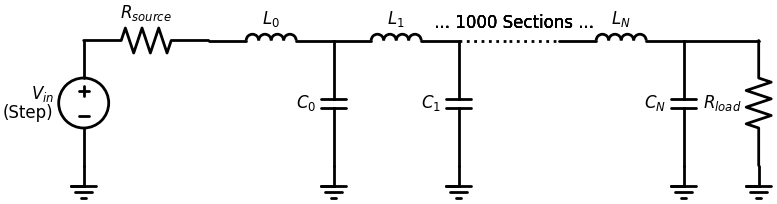

In [ ]:
import schemdraw
import schemdraw.elements as elm


def draw_ladder_schematic():
    with schemdraw.Drawing() as d:
        d.config(fontsize=12, unit=2.5)

        d.add(elm.Ground())

        src = d.add(elm.SourceV().up().label("$V_{in}$\n(Step)"))
        d.add(elm.Resistor().right().at(src.end).label("$R_{source}$"))

        # Save the current position
        current_node = d.here

        for i in range(2):
            # Inductor (Series)
            l_symbol = d.add(elm.Inductor().right().at(current_node).label(f"$L_{i}$"))

            current_node = l_symbol.end

            # Capacitor (Shunt to Ground)
            d.add(elm.Capacitor().down().at(current_node).label(f"$C_{i}$"))
            d.add(elm.Ground())

        d.add(elm.Line().right().length(1).at(current_node).linestyle("dotted"))

        # Add the text label in the gap
        d.add(
            elm.Label()
            .label(f" ... {N_SECTIONS} Sections ... ", ofst=(0, 0.25))
            .at(d.here)
        )

        # Another dashed line picking up after the gap
        d.add(elm.Line().right().length(1).linestyle("dotted"))

        current_node = d.here

        l_last = d.add(elm.Inductor().right().at(current_node).label("$L_{N}$"))

        current_node = l_last.end

        d.add(elm.Capacitor().down().at(current_node).label("$C_{N}$"))
        d.add(elm.Ground())

        d.add(elm.Line().right().length(1.5).at(current_node))
        d.add(elm.Resistor().down().label("$R_{load}$"))
        d.add(elm.Ground())


# Generate the diagram
draw_ladder_schematic()

Generating 1000-stage LC Ladder...
Compilation finished in 0.1101s
System Matrix Size: 2004x2004 (4016016 elements)
Solving DC Operating Point...
Running Transient Simulation...


100.00%|██████████| [00:01<00:00, 97.18%/s]


   ✅ Simulation Successful
Simulation completed in 1.5932s
Total Steps: 3031


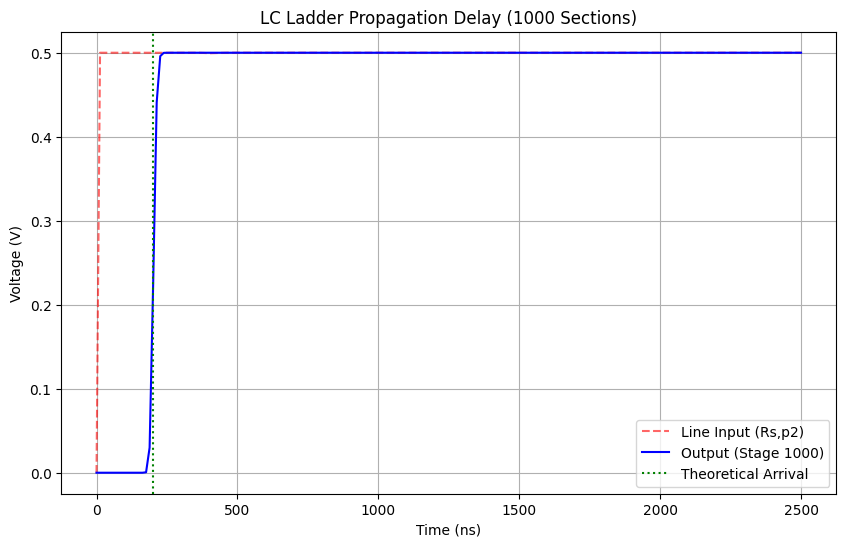

In [7]:
models_map = {
    "resistor": Resistor,
    "capacitor": Capacitor,
    "inductor": Inductor,
    "voltage_source": SmoothPulse,
    "ground": lambda: 0,
}


print(f"Generating {N_SECTIONS}-stage LC Ladder...")
net_dict = create_lc_ladder(N_SECTIONS)

t0_compile = time.time()
groups, sys_size, port_map = compile_netlist(net_dict, models_map)
print(f"Compilation finished in {time.time() - t0_compile:.4f}s")
print(f"System Matrix Size: {sys_size}x{sys_size} ({sys_size**2} elements)")

linear_strat = analyze_circuit(groups, sys_size, is_complex=False)

print("Solving DC Operating Point...")
y0 = linear_strat.solve_dc(groups, jnp.zeros(sys_size))

transient_sim = setup_transient(groups=groups, linear_strategy=linear_strat)

print("Running Transient Simulation...")

term = diffrax.ODETerm(lambda t, y, args: jnp.zeros_like(y))

step_controller = diffrax.PIDController(
    rtol=1e-3,
    atol=1e-4,
    pcoeff=0.2,
    icoeff=0.5,
    dcoeff=0.0,
    force_dtmin=True,
    dtmin=1e-14,
    dtmax=1e-9,
    error_order=2,
)

t0_sim = time.time()
sol = transient_sim(
    t0=0.0,
    t1=T_MAX,
    dt0=1e-11,
    y0=y0,
    stepsize_controller=step_controller,
    max_steps=1000000,
    saveat=diffrax.SaveAt(ts=jnp.linspace(0, T_MAX, 200)),
    progress_meter=diffrax.TqdmProgressMeter(refresh_steps=100),
)

if sol.result == diffrax.RESULTS.successful:
    print("   ✅ Simulation Successful")

    t_end_sim = time.time()
    print(f"Simulation completed in {t_end_sim - t0_sim:.4f}s")
    print(f"Total Steps: {sol.stats['num_steps']}")

    node_out_idx = port_map["Rl,p1"]
    node_in_idx = port_map["Rs,p2"]

    ts = sol.ts * 1e9
    v_in = sol.ys[:, node_in_idx]
    v_out = sol.ys[:, node_out_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(ts, v_in, "r--", alpha=0.6, label="Line Input (Rs,p2)")
    plt.plot(ts, v_out, "b-", linewidth=1.5, label=f"Output (Stage {N_SECTIONS})")

    plt.title(f"LC Ladder Propagation Delay ({N_SECTIONS} Sections)")
    plt.xlabel("Time (ns)")
    plt.ylabel("Voltage (V)")
    plt.legend(loc="upper left")
    plt.grid(True)

    theory_delay = N_SECTIONS * jnp.sqrt(10e-9 * 4e-12) * 1e9
    plt.axvline(
        theory_delay + 1.0, color="green", linestyle=":", label="Theoretical Arrival"
    )
    plt.legend()

    plt.show()
else:
    print("   ❌ Simulation Failed")
    print(f"   Result Code: {sol.result}")